# Disciplina: Aprendizagem por Reforço
**Aluno:** Julio Cezar Soares Silva

**Professor:** Hansenclever Bassani 

**Exercício 2.5**
Design and conduct an experiment to demonstrate the
dificulties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the q*(a) start out equal and then take
independent random walks (say by adding a normally distributed increment with mean
zero and standard deviation 0.01 to all the q*(a) on each step). Prepare plots like
Figure 2.2 for an action-value method using sample averages, incrementally computed,
and another action-value method using a constant step-size parameter, alpha = 0.1. Use
epsilon = 0.1 and longer runs, say of 10,000 steps.

Primeiro são feitos os imports

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns

# Visualizando a criação de bandits

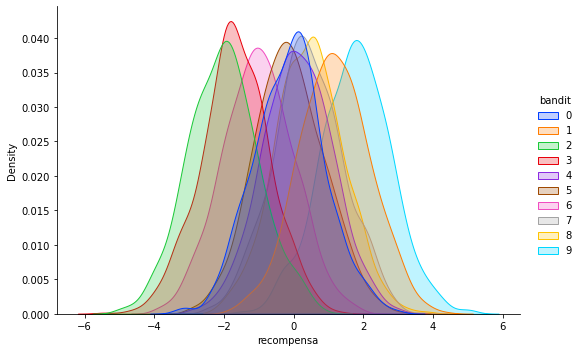

In [ ]:
# parametros de criação dos bandits
n_bandits = 10
mu_base, sigma_base = 0, 1 # base: mean and standard deviation

# criação dos bandits (cada um tem médias diferentes, mas std = sigma_base)
bandits = []
for a in range(n_bandits): # loop sobre todos os bandits
  bandits.append(np.random.normal(mu_base, sigma_base)) # amostrar a média deste bandit

# plotar a distribuição estacionária de cada bandit criado
n_samples = 1000
data = dict([])
data['recompensa'] = []
data['bandit'] = []
for s in range(n_samples):
  for a in range(n_bandits):
    data['recompensa'].append(np.random.normal(bandits[a], sigma_base))
    data['bandit'].append(a)

df = pd.DataFrame(data)
sns.displot(data=df, x='recompensa', hue='bandit', kind='kde', fill=True, palette=sns.color_palette('bright')[:n_bandits], height=5, aspect=1.5)

## Validação do algoritmo - Experimentos com simple bandit para distribuições estacionárias

Simulação atual = 0
Simulação atual = 1
Simulação atual = 2
Simulação atual = 3
Simulação atual = 4
Simulação atual = 5
Simulação atual = 6
Simulação atual = 7
Simulação atual = 8
Simulação atual = 9
Simulação atual = 10
Simulação atual = 11
Simulação atual = 12
Simulação atual = 13
Simulação atual = 14
Simulação atual = 15
Simulação atual = 16
Simulação atual = 17
Simulação atual = 18
Simulação atual = 19
Simulação atual = 20
Simulação atual = 21
Simulação atual = 22
Simulação atual = 23
Simulação atual = 24
Simulação atual = 25
Simulação atual = 26
Simulação atual = 27
Simulação atual = 28
Simulação atual = 29
Simulação atual = 30
Simulação atual = 31
Simulação atual = 32
Simulação atual = 33
Simulação atual = 34
Simulação atual = 35
Simulação atual = 36
Simulação atual = 37
Simulação atual = 38
Simulação atual = 39
Simulação atual = 40
Simulação atual = 41
Simulação atual = 42
Simulação atual = 43
Simulação atual = 44
Simulação atual = 45
Simulação atual = 46
Simulação atual = 47
Si

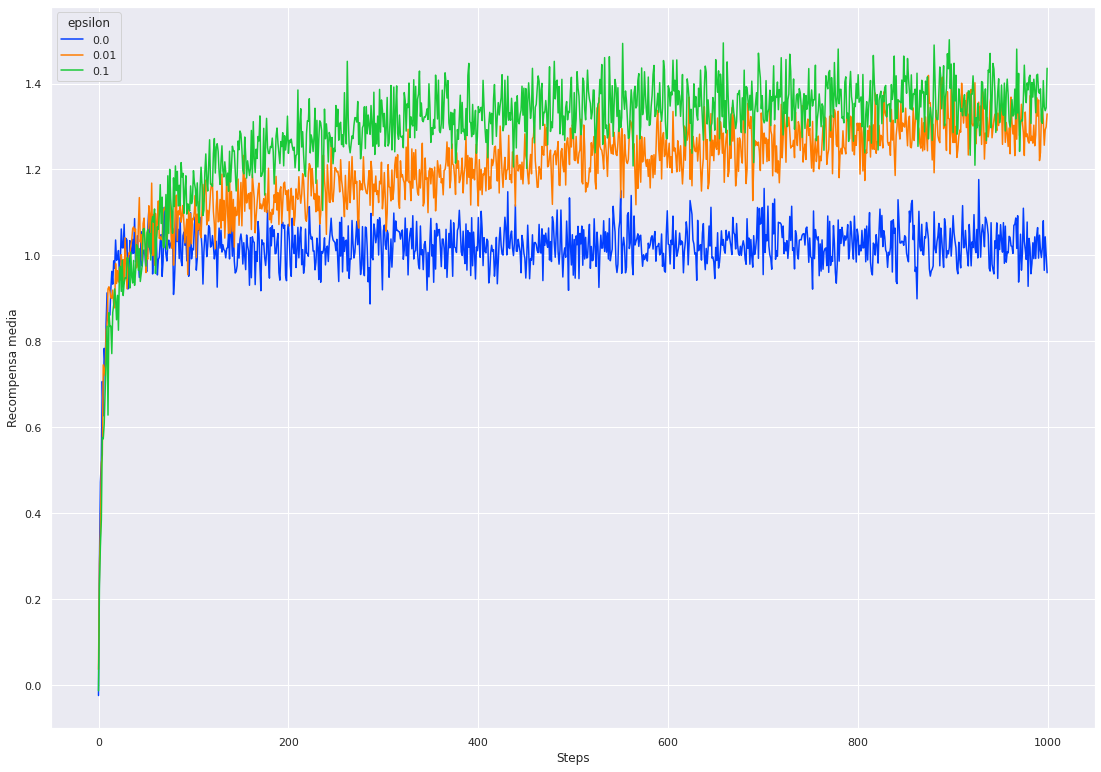

In [27]:
# parametros de criação dos bandits
n_bandits = 10
mu_base, sigma_base = 0, 1 # base: mean and standard deviation

#configurar parametros do learner
nRuns = 500 # numero de simulações de problemas diferentes
T = 1000 # horizonte de tempo do experimento em cada experimento
epsilons = [0, 0.01, 0.1] # epsilon-greedy
actions = [a for a in range(n_bandits)]

# preparar outputs dos experimentos 
data_results = dict([])
data_results['Steps'] = []
data_results['epsilon'] = []
R_sum = dict([])# usado para calcular a recompensa média em cada step no final
for epsilon in epsilons:
  for t in range(T):
    data_results['epsilon'].append(epsilon)
    data_results['Steps'].append(t)
    R_sum[str(t) + str(epsilon)] = 0

# iniciar experimentos
for run in range(nRuns):
  print("Simulação atual = " + str(run))
  # criação dos bandits (cada um tem médias diferentes, mas std = sigma_base)
  bandits = []
  for a in range(n_bandits): # loop sobre todos os bandits
    bandits.append(np.random.normal(mu_base, sigma_base)) # amostrar a média deste bandit
  for epsilon in epsilons:
    # inicializar Q(a) e N(a)
    Q = []
    N = []
    for a in range(n_bandits):
      Q.append(0)
      N.append(0)
    for t in range(T):
      # exploration vs exploitation
      p = np.random.uniform(low=0.0, high=1.0)
      A = None
      if p <= epsilon: # exploration 
          A = np.random.choice(actions)
      else: # exploitation
          max_value = max(Q)
          A = np.argwhere(Q == np.amax(Q)).flatten().tolist()
          if len(A) > 1: # se houve empate
            A = np.random.choice(A)
          else:
            A = A[0]
      # realizar a ação e ganhar recompensa
      R = np.random.normal(bandits[A], sigma_base) 
      # atualizar N(A) e Q(A)
      N[A] += 1
      Q[A] += (1/N[A])*(R - Q[A])
      # atualizar dados do experimento
      R_sum[str(t) + str(epsilon)] += R

# calcular recompensa média em todos os steps
data_results['Recompensa media'] = []
for epsilon in epsilons:
  for t in range(T):
    data_results['Recompensa media'].append(R_sum[str(t) + str(epsilon)]/nRuns)

print("fim...plotando...")
df = pd.DataFrame(data_results)
sns.set(rc={'figure.figsize':(18.7,13.27)})
sns.lineplot(data=df, x="Steps", hue = 'epsilon', y="Recompensa media", palette=sns.color_palette('bright')[:len(epsilons)])




# Experimentos com distribuições que variam ao longo do tempo

Simulação atual = 0
Simulação atual = 1
Simulação atual = 2
Simulação atual = 3
Simulação atual = 4
Simulação atual = 5
Simulação atual = 6
Simulação atual = 7
Simulação atual = 8
Simulação atual = 9
Simulação atual = 10
Simulação atual = 11
Simulação atual = 12
Simulação atual = 13
Simulação atual = 14
Simulação atual = 15
Simulação atual = 16
Simulação atual = 17
Simulação atual = 18
Simulação atual = 19
Simulação atual = 20
Simulação atual = 21
Simulação atual = 22
Simulação atual = 23
Simulação atual = 24
Simulação atual = 25
Simulação atual = 26
Simulação atual = 27
Simulação atual = 28
Simulação atual = 29
Simulação atual = 30
Simulação atual = 31
Simulação atual = 32
Simulação atual = 33
Simulação atual = 34
Simulação atual = 35
Simulação atual = 36
Simulação atual = 37
Simulação atual = 38
Simulação atual = 39
Simulação atual = 40
Simulação atual = 41
Simulação atual = 42
Simulação atual = 43
Simulação atual = 44
Simulação atual = 45
Simulação atual = 46
Simulação atual = 47
Si

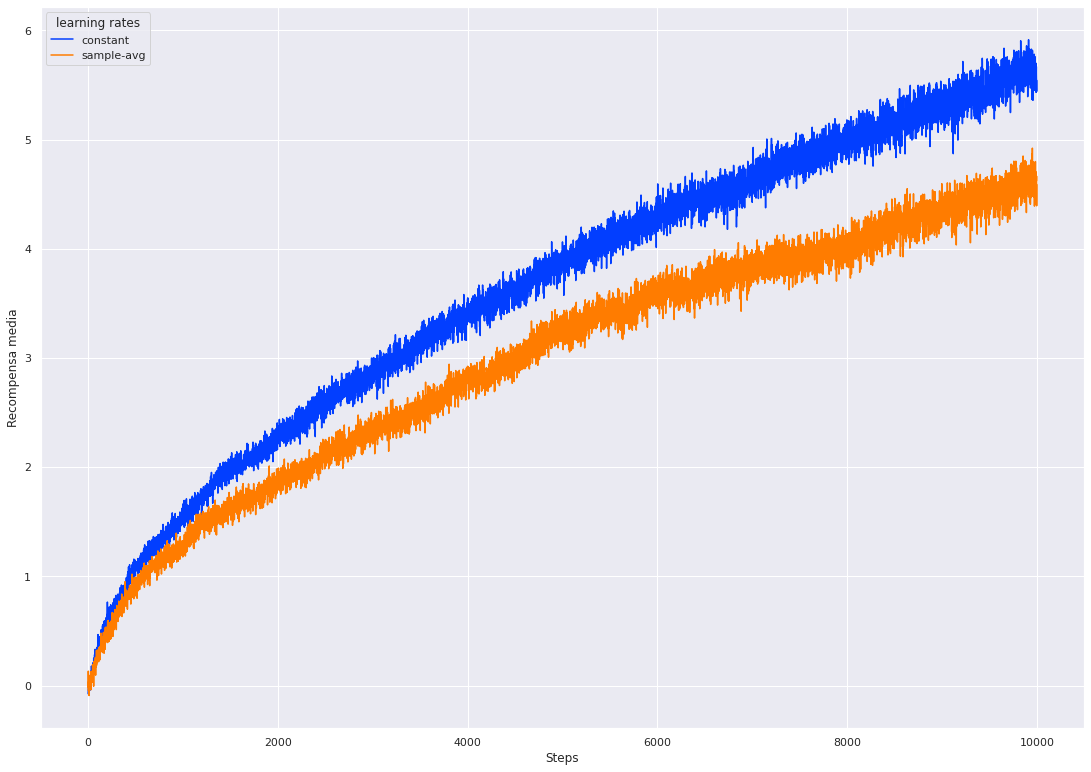

In [32]:
# parameteros dos experimentos
nRuns = 500 # numero de simulações de problemas diferentes
T = 10000 # horizonte de tempo do experimento em cada experimento

# parametros de criação dos bandits
n_bandits = 10
mu_base, sigma_base = 0, 1 # base: mean and standard deviation

#configurar parametros do learner
epsilon = 0.1 # fixo
learn_rates = ['constant','sample-avg']
actions = [a for a in range(n_bandits)]

# preparar outputs dos experimentos 
data_results = dict([])
data_results['Steps'] = []
data_results['learning rates'] = []
R_sum = dict([])# usado para calcular a recompensa média em cada step no final
for alpha in learn_rates:
  for t in range(T):
    data_results['learning rates'].append(alpha)
    data_results['Steps'].append(t)
    R_sum[str(t) + alpha] = 0

# iniciar experimentos
for run in range(nRuns):
  print("Simulação atual = " + str(run))
  # criação dos bandits nao estacionarios
  bandits = dict([])
  for t in range(T):
    for a in range(n_bandits): # loop sobre todos os bandits
      if t == 0:  # amostrar a média inicial deste bandit
        bandits[str(a)+str(t)] = 0
      else: # atualizar a média deste bandit
        bandits[str(a)+str(t)] = bandits[str(a)+str(t-1)] + np.random.normal(mu_base, 0.04)
  for alpha in learn_rates:
    # inicializar Q(a) e N(a)
    Q = []
    N = []
    for a in range(n_bandits):
      Q.append(0)
      N.append(0)
    for t in range(T):
      # exploration vs exploitation
      p = np.random.uniform(low=0.0, high=1.0)
      A = None
      if p <= epsilon: # exploration 
          A = np.random.choice(actions)
      else: # exploitation
          max_value = max(Q)
          A = np.argwhere(Q == np.amax(Q)).flatten().tolist()
          if len(A) > 1: # se houve empate
            A = np.random.choice(A)
          else:
            A = A[0]
      # realizar a ação e ganhar recompensa
      R = np.random.normal(bandits[str(A)+str(t)], sigma_base) 
      # atualizar N(A) e Q(A)
      N[A] += 1
      if alpha == 'constant':
        Q[A] += 0.1*(R - Q[A])
      else:
        Q[A] += (1/N[A])*(R - Q[A])
      # atualizar dados do experimento
      R_sum[str(t) + alpha] += R



# calcular recompensa média em todos os steps
data_results['Recompensa media'] = []
for alpha in learn_rates:
  for t in range(T):
    data_results['Recompensa media'].append(R_sum[str(t) + alpha]/nRuns)

print("fim...plotando...")
df = pd.DataFrame(data_results)
sns.set(rc={'figure.figsize':(18.7,13.27)})
sns.lineplot(data=df, x="Steps", hue = 'learning rates', y="Recompensa media", palette=sns.color_palette('bright')[:len(learn_rates)])

Percebe-se que métodos do tipo sample-average não conseguem obter um ganho consistente, que reflita a mudança nas recompensas ao longo do tempo. O aprendizado fica mais lento ao longo do tempo, dado que a taxa de aprendizado deste método tende a zero quanto t aumenta. Porém, percebe-se que o método usando taxa de aprendizado constante atualiza seu conhecimento mais rapidamente, seguindo as mudanças mais recentes mais precisamente que o sample-average.